# **Лабораторная работа №3**
Выполнилa: Ажаурова Александра Константиновна  
Группа: М8О-303Б-22


## Задача

### Цель:
Развить навыки анализа, подготовки данных и построения моделей решающих задачу линейной регрессии по набору данных.

Ваша цель - предсказать Weekly_Sales на 4 измерения вперед(на месяц).  
Для успешного прохождения соревнования в рамках лабораторной работы необходимо получить значение MAPE менее чем 0.12.  
Порог прохождения лабораторки - MAPE(%) - 10% (Score on leaderboard < 0.1)

Разрешено использование сколь угодно сложных моделей, кроме древесных(бустинг, деревья, леса). В том числе для подготовки данных.

### Dataset Description:
Классическая задача прогноза продаж в сети магазинов.

Разные магазины в зависимости от различных факторов могут иметь различные продажи. Чтобы понять сколько товара нужно поставить в магазин, какая ожидается выручка и т.п. нам необходимо уметь предсказывать продажи в магазинах в зависимости от региона, сезона, температуры на улице, стоимости топлива, экономической ситуации и т.д.

Ваша задача предсказать продажи магазина на месяц вперед(4 недели) на основе истории.

### Файлы:
- train.csv - тренировочный набор данных. С этим набором вы делаете все что хотите, там есть true значения и все фичи.
- test.csv - тестовый набор данных. Здесь вам истинные значения будут не известны. Вы лишь можете сделать сабмит с помощью этого набора.


## Описание столбцов
| Столбец             | Тип данных  | Описание                                                                                                     |
|---------------------|-------------|--------------------------------------------------------------------------------------------------------------|
| `Store`           | int         | ID магазина                                                                                                  |
| `Date`            | date        | Дата записи (день, месяц, год)                                                                               |
| `Weekly_Sales`    | float       | Продажи за неделю для данного магазина (только в `train.csv`, целевая переменная)                            |
| `Temperature`     | float       | Средняя температура за неделю в городе, где находится магазин (в градусах Фаренгейта)                        |
| `Fuel_Price`      | float       | Цена топлива в данном регионе за неделю                                                                      |
| `CPI`             | float       | Индекс потребительских цен                                                                                   |
| `Unemployment`    | float       | Уровень безработицы в регионе                                                                                |

- **`train.csv`** содержит целевую переменную `Weekly_Sales`, которую нужно предсказать, используя остальные признаки.
- **`test.csv`** не имеет `Weekly_Sales`, так как он предназначен для предсказания. 

Эти столбцы, кроме `Weekly_Sales` в `train.csv`, будут использоваться как признаки для построения модели прогнозирования.

## Решение


### 1. Импорт библиотек и загрузка данных

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error
from datetime import timedelta
import holidays
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.holtwinters import ExponentialSmoothing


# Загрузка данных
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Просмотр первых строк данных для понимания структуры
print("Train Data:")
print(train.head())

print("\nTest Data:")
print(test.head())

Train Data:
   Store        Date  Weekly_Sales  Temperature  Fuel_Price         CPI  \
0      1  2010-01-10    1453329.50        71.89       2.603  211.671989   
1      1  2010-02-04    1594968.28        62.27       2.719  210.820450   
2      1  2010-02-07    1492418.14        80.91       2.669  211.223533   
3      1  2010-02-19    1611968.17        39.93       2.514  211.289143   
4      1  2010-02-26    1409727.59        46.63       2.561  211.319643   

   Unemployment  
0         7.838  
1         7.808  
2         7.787  
3         8.106  
4         8.106  

Test Data:
   Store        Date  Temperature  Fuel_Price         CPI  Unemployment
0      1  2012-10-19        67.97       3.594  223.425723         6.573
1      1  2012-10-26        69.16       3.506  223.444251         6.573
2      1  2012-11-05        73.77       3.688  221.725663         7.143
3      1  2012-12-10        62.99       3.601  223.381296         6.573
4      2  2012-10-19        68.08       3.594  223.059808

### 2. Анализ данных

График средних продаж по неделям для каждого месяца

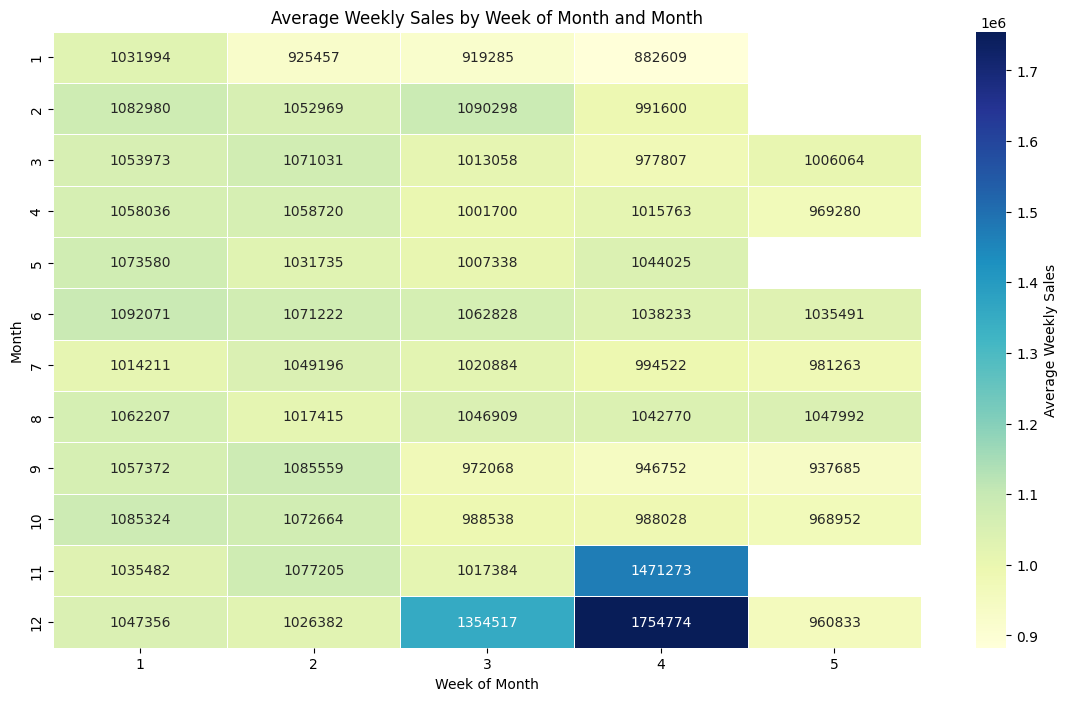

In [2]:
# Преобразование даты в формат datetime
train['Date'] = pd.to_datetime(train['Date'])
train['Week'] = train['Date'].dt.isocalendar().week
train['Month'] = train['Date'].dt.month
train['DayOfWeek'] = train['Date'].dt.dayofweek
train['Year'] = train['Date'].dt.year
train['DayOfYear'] = train['Date'].dt.dayofyear
train['MonthDay'] = train['Date'].dt.strftime('%m-%d')

# Добавляем столбец 'WeekOfMonth', который определяет номер недели в месяце
train['WeekOfMonth'] = train['Date'].apply(lambda d: (d.day - 1) // 7 + 1)

# Средние продажи по неделям и месяцам
monthly_weekly_sales = train.groupby(['Month', 'WeekOfMonth'])['Weekly_Sales'].mean().unstack()

# Построение графика
plt.figure(figsize=(14, 8))
sns.heatmap(monthly_weekly_sales, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': 'Average Weekly Sales'})
plt.xlabel('Week of Month')
plt.ylabel('Month')
plt.title('Average Weekly Sales by Week of Month and Month')
plt.show()


График суммарных покупок по дням недели

C:\Users\71245\AppData\Local\Temp\ipykernel_27348\2778759997.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=daily_sales.index, y=daily_sales.values, palette='viridis')


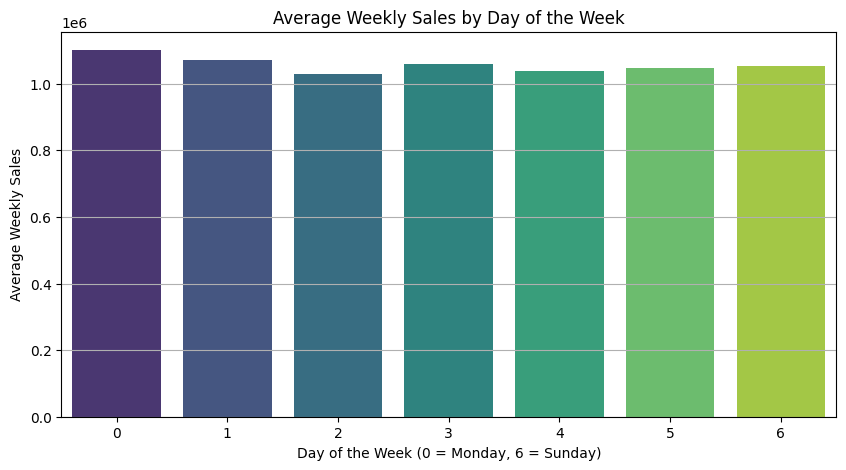

In [3]:
# Средние продажи по дням недели
daily_sales = train.groupby('DayOfWeek')['Weekly_Sales'].mean()

plt.figure(figsize=(10, 5))
sns.barplot(x=daily_sales.index, y=daily_sales.values, palette='viridis')
plt.xlabel('Day of the Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Day of the Week')
plt.grid(axis='y')
plt.show()

График продаж по месяцам

C:\Users\71245\AppData\Local\Temp\ipykernel_27348\2247657082.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_sales.index, y=monthly_sales.values, palette='plasma')


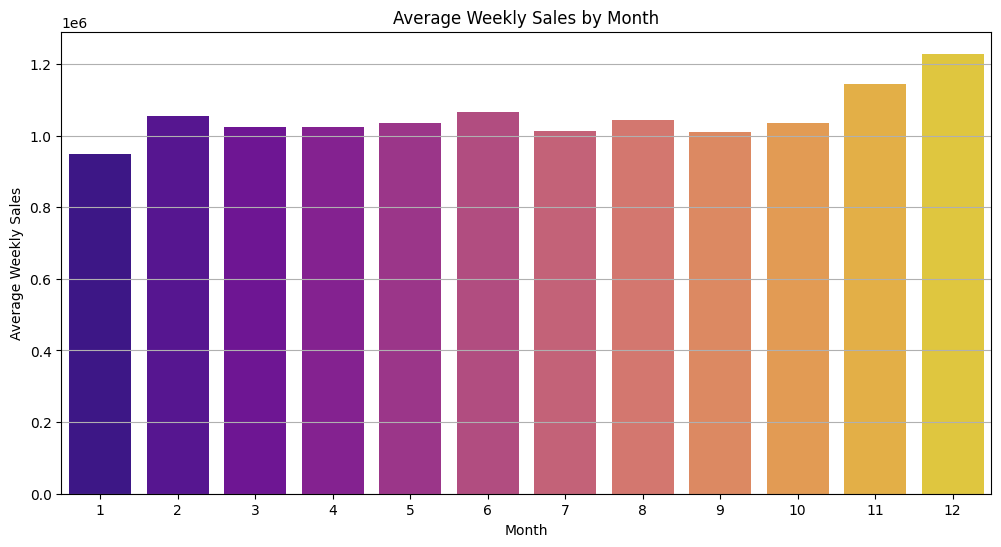

In [4]:
# Средние продажи по месяцам
monthly_sales = train.groupby('Month')['Weekly_Sales'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_sales.index, y=monthly_sales.values, palette='plasma')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Month')
plt.grid(axis='y')
plt.show()

Детальный анализ - наложение кривой каждого года друг на друга

In [5]:
# Группировка данных по дню года и году, чтобы получить средние продажи для каждого дня в году
daily_sales = train.groupby(['Year', 'DayOfYear'])['Weekly_Sales'].mean().reset_index()

# Создание интерактивного графика
fig = px.line(daily_sales, x='DayOfYear', y='Weekly_Sales', color='Year',
              title="Average Weekly Sales by Day of Year with Annual Overlap",
              labels={'Weekly_Sales': 'Average Weekly Sales', 'DayOfYear': 'Day of Year', 'Year': 'Year'})

# Настройка отображения подсказок с точной датой
fig.update_traces(mode='markers+lines', hovertemplate='Year: %{legendgroup}<br>Day of Year: %{x}<br>Sales: %{y:.2f}')

# Установка сетки по дням и настройка графика
fig.update_xaxes(
    tick0=0,  # Начало оси с нулевого дня года (чисто для удобства просмотра)
    dtick=10,  # Отображение меток каждые 10 дней
    showgrid=True, 
    gridwidth=0.5, 
    gridcolor='lightgrey'
)

# Добавление сетки по оси Y
fig.update_yaxes(
    showgrid=True, 
    gridwidth=0.5, 
    gridcolor='lightgrey'
)

# Показ интерактивного графика
fig.write_html("sales_trend.html")

Влияние факторов на продажи

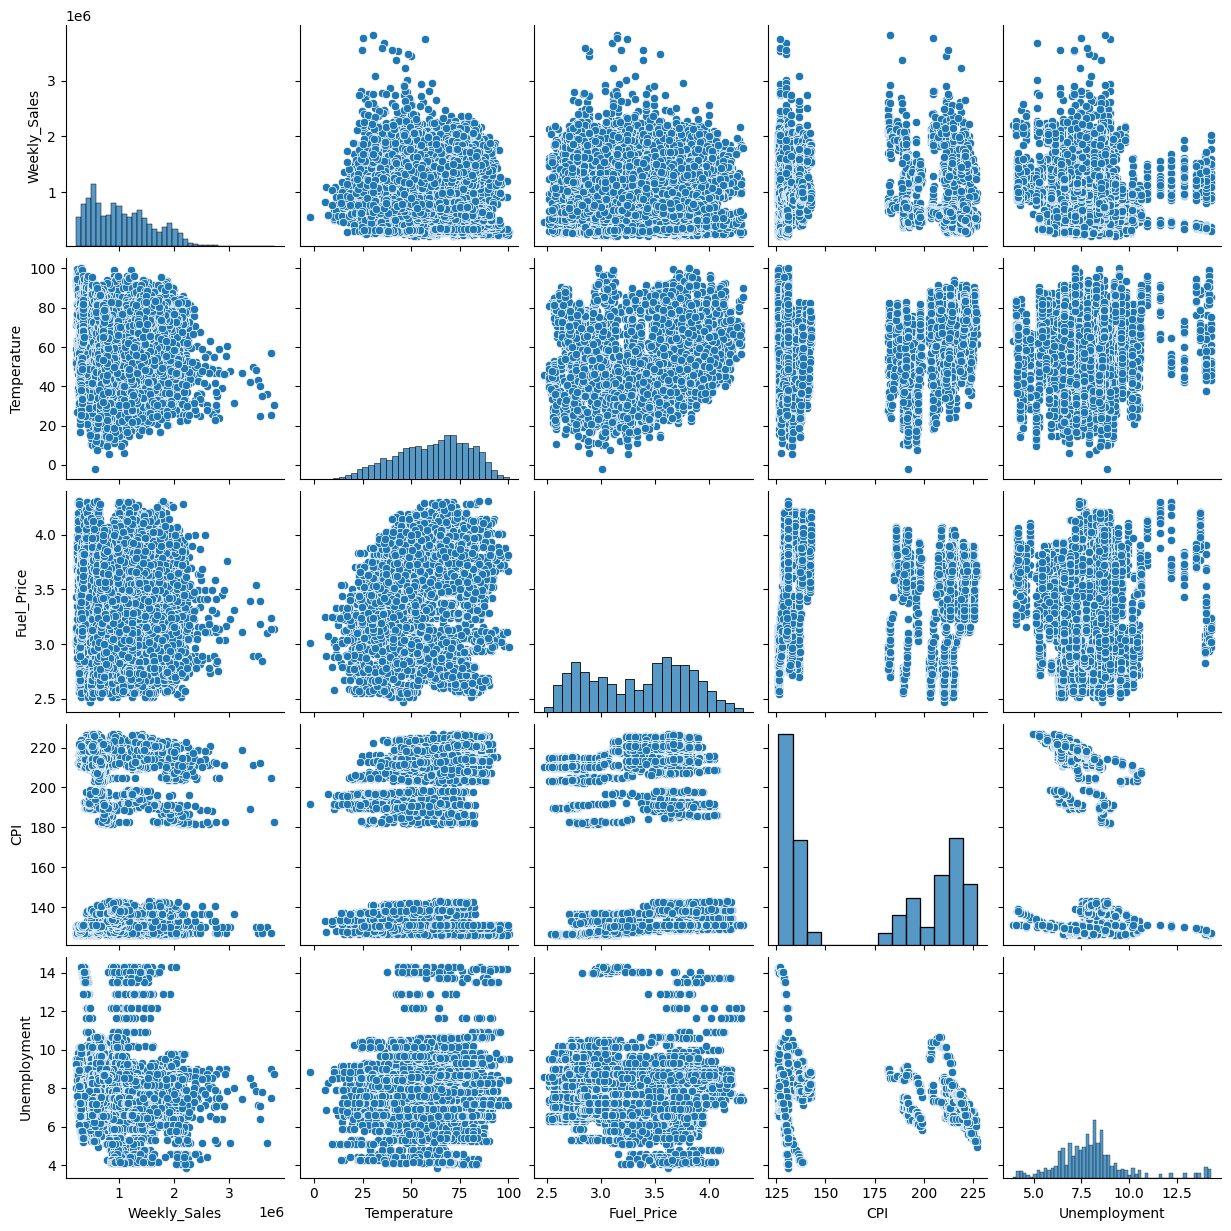

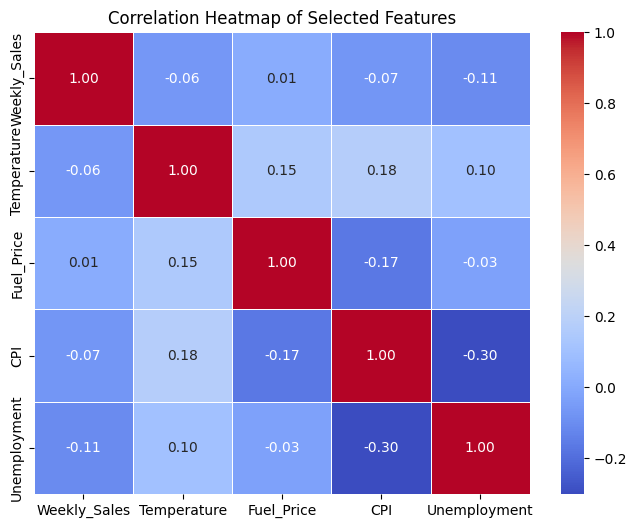

In [6]:
# Параграфики между признаками и целевой переменной Weekly_Sales
sns.pairplot(train[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']])
plt.show()

# Вычисление корреляционной матрицы для числовых признаков
# Выбор только тех признаков, которые важны для анализа корреляции с Weekly_Sales
selected_features = train[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]

# Вычисление корреляционной матрицы для выбранных признаков
corr_matrix = selected_features.corr()

# Построение тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features")
plt.show()

### Выводы из блока анализа
#### Корреляционная матрица
Корреляционная матрица показывает, как связаны между собой разные признаки в наборе данных. Каждый элемент в таблице представляет коэффициент корреляции между парой признаков, который измеряется от -1 до 1:

- **Коэффициент корреляции 1** показывает идеальную положительную связь (когда одно значение увеличивается, другое также увеличивается пропорционально).
- **Коэффициент -1** показывает идеальную отрицательную связь (одно значение растет, другое уменьшается пропорционально).
- **Коэффициент 0** означает, что связи между признаками практически нет.

Разберем конкретные примеры из матрицы:
- **Unemployment и CPI** имеют корреляцию -0.30, что указывает на слабую отрицательную связь между потребительскими ценами и уровнем безработицы.
- **Temperature и CPI** имеет корреляцию 0.18, что указывает на слабую положительную связь между потребительскими ценами и температурой.
- **Fuel_Price и CPI** имеет корреляцию -0.17, что указывает на слабую отрицательную связь между потребительскими ценами и ценами на бензин.
- между остальными признаками корреляция еще более близится к нулю, а следовательно у них связи практически нет.

#### Параграфики между признаками
1. **Первая строка** — **Weekly Sales**:
   - **Weekly Sales vs Weekly Sales**: гистограмма распределения недельных продаж. Видно, что большинство продаж сконцентрировано на уровне около 1 миллиона, с несколькими выбросами до 3.5 миллионов.
   - **Weekly Sales vs Temperature**: показывает, как температура может влиять на продажи. Здесь можно видеть, что продажи равномерно распределены по всем температурам, что может означать слабую зависимость.
   - **Weekly Sales vs Fuel Price**: показывает связь между ценой на топливо и продажами. Заметно, что продажи также равномерно распределены при различных ценах на топливо.
   - **Weekly Sales vs CPI**: отражает влияние индекса потребительских цен на продажи. Здесь можно увидеть некоторые кластеры, что может говорить о наличии зависимости, но она неявная.
   - **Weekly Sales vs Unemployment**: показывает зависимость продаж от уровня безработицы. Данные также распределены равномерно, хотя видно, что при некоторых значениях безработицы наблюдаются более высокие продажи.

2. **Вторая строка** — **Temperature**:
   - **Temperature vs Weekly Sales**: аналогично предыдущим, продажа не сильно зависит от температуры.
   - **Temperature vs Temperature**: гистограмма распределения температуры. Видно, что значения температуры равномерно распределены по диапазону от 0 до 100.
   - **Temperature vs Fuel Price**: диаграмма рассеяния, показывающая слабую или отсутствующую корреляцию между температурой и ценой на топливо.
   - **Temperature vs CPI**: диаграмма рассеяния, где также нет явной корреляции между температурой и CPI.
   - **Temperature vs Unemployment**: диаграмма рассеяния, показывающая отсутствие зависимости между температурой и уровнем безработицы.

3. **Третья строка** — **Fuel Price**:
   - **Fuel Price vs Weekly Sales**: аналогично предыдущим, зависимости между ценой на топливо и продажами не наблюдается.
   - **Fuel Price vs Temperature**: аналогично, зависимости между ценой на топливо и температурой нет.
   - **Fuel Price vs Fuel Price**: гистограмма распределения цен на топливо. Видно, что цена в основном варьируется в диапазоне от 2.5 до 4.25.
   - **Fuel Price vs CPI**: диаграмма рассеяния, показывающая, что зависимости между ценой на топливо и CPI также не наблюдается.
   - **Fuel Price vs Unemployment**: диаграмма рассеяния, где видна слабая или отсутствующая корреляция между ценой на топливо и уровнем безработицы.

4. **Четвёртая строка** — **CPI**:
   - **CPI vs Weekly Sales**: аналогично предыдущим, явной зависимости между CPI и продажами нет.
   - **CPI vs Temperature**: отсутствие связи между CPI и температурой.
   - **CPI vs Fuel Price**: зависимость между CPI и ценой на топливо также не прослеживается.
   - **CPI vs CPI**: гистограмма распределения CPI, где видны две основные группы значений (около 140 и 200).
   - **CPI vs Unemployment**: некоторая кластеризация, возможно, указывает на слабую взаимосвязь между CPI и уровнем безработицы, хотя явной зависимости не видно.

5. **Пятая строка** — **Unemployment**:
   - **Unemployment vs Weekly Sales**: отсутствие корреляции между уровнем безработицы и продажами.
   - **Unemployment vs Temperature**: зависимости между уровнем безработицы и температурой не наблюдается.
   - **Unemployment vs Fuel Price**: отсутствие зависимости между уровнем безработицы и ценой на топливо.
   - **Unemployment vs CPI**: слабая корреляция между CPI и уровнем безработицы, хотя она не явно выражена.
   - **Unemployment vs Unemployment**: гистограмма распределения уровня безработицы, где видно, что большинство значений находятся в диапазоне от 6 до 10.

**Итог**: В целом, данные графики показывают, что корреляция между продажами и выбранными факторами может быть слабой, так как точки в большинстве графиков распределены случайным образом без выраженной тенденции.  

График продаж по месяцам демонстрирует заметный спад в январе и значительный рост в ноябре и декабре.  
Данные по дням недели не показывают существенных изменений в продажах.  
На графике средних продаж по неделям для каждого месяца виден резкий рост в последней неделе ноября, а также в 3-й и 4-й неделях декабря.  
При детальном анализе, накладывая данные по годам, сохраняются эти тенденции, а также выявляются выбросы, отражающие временные тренды.

Рассмотрим каждый магазин отдельно

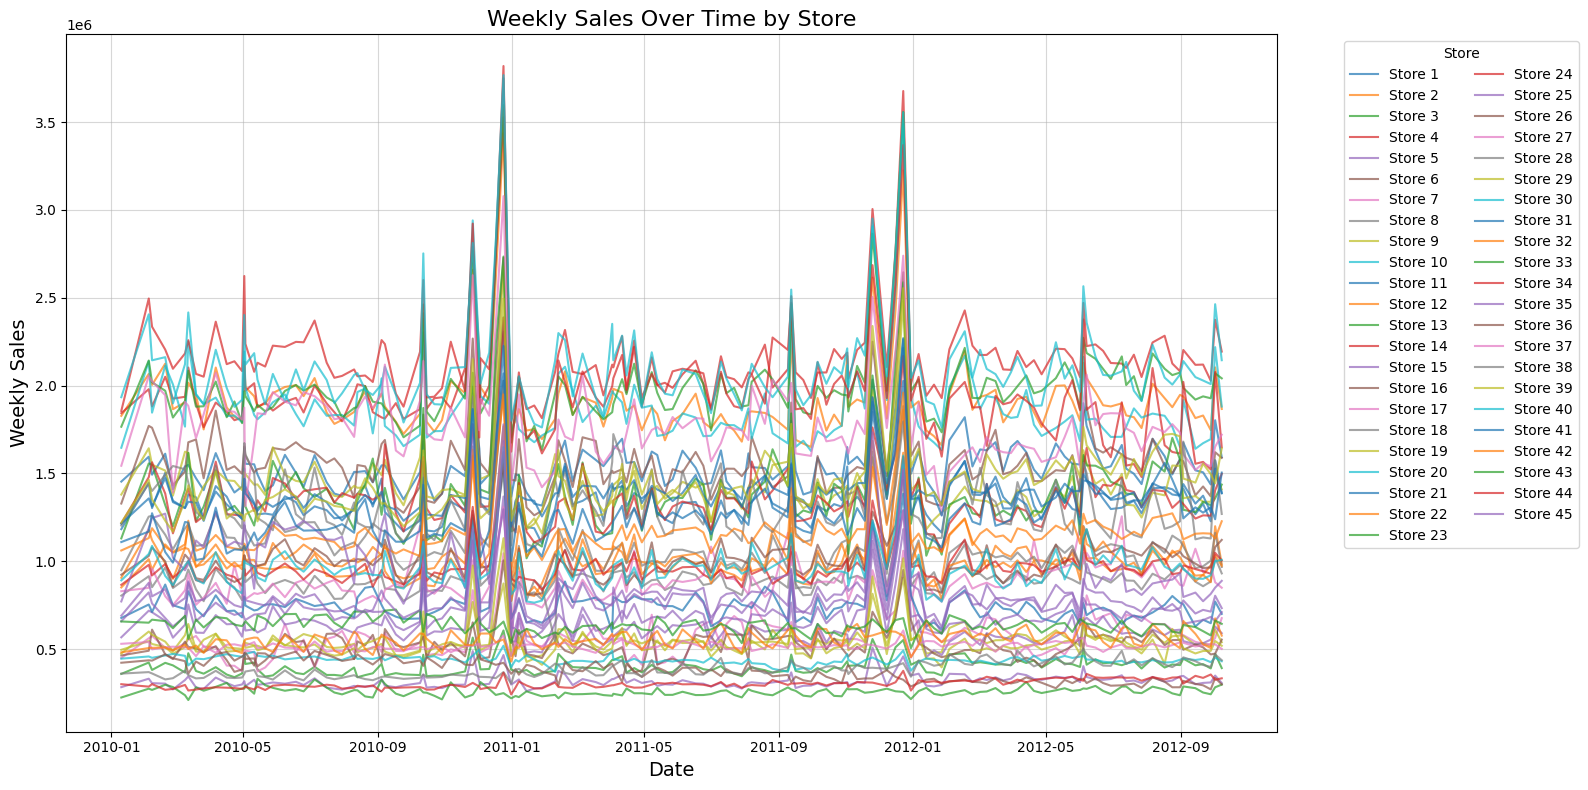

In [7]:
# Группировка данных по магазинам и времени для суммирования продаж
store_sales = train.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()

# Создание графика для всех магазинов
plt.figure(figsize=(16, 8))
for store_id in store_sales['Store'].unique():
    store_data = store_sales[store_sales['Store'] == store_id]
    plt.plot(store_data['Date'], store_data['Weekly_Sales'], label=f'Store {store_id}', alpha=0.7)

# Настройка графика
plt.title('Weekly Sales Over Time by Store', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)

# Создание легенды в два столбца
plt.legend(
    title='Store',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    ncol=2  # Указываем два столбца для удобства просмотра
)
plt.grid(alpha=0.5)
plt.tight_layout()

# Отображение графика
plt.show()


C:\Users\71245\AppData\Local\Temp\ipykernel_27348\998272879.py:25: RuntimeWarning:

Mean of empty slice



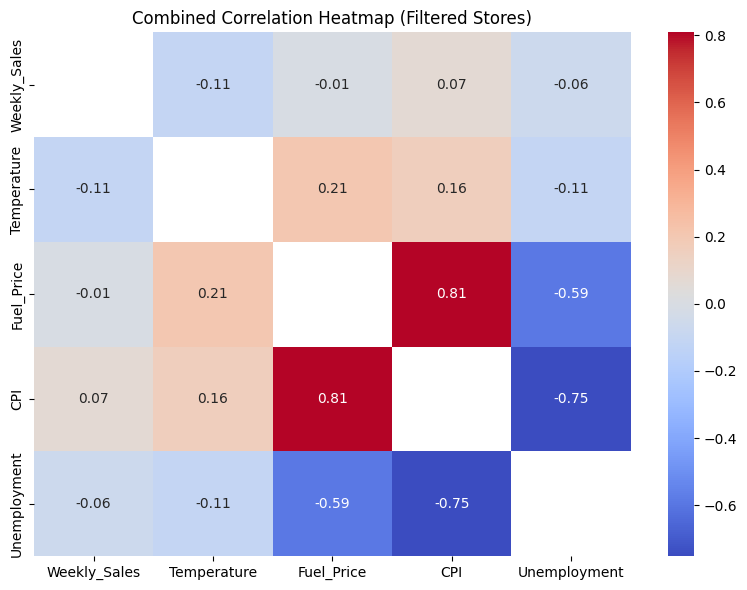

In [8]:
# Получение списка магазинов
stores = train['Store'].unique()

# Инициализация списка для хранения матриц, соответствующих условию
filtered_correlation_matrices = []

# Генерация корреляционных матриц для каждого магазина
for store_id in stores:
    # Отбор данных для конкретного магазина
    store_data = train[train['Store'] == store_id]
    
    # Вычисление корреляции
    corr_matrix = store_data[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()
    
    # Удаление диагонали (устанавливаем NaN, чтобы не учитывать единицы на диагонали)
    np.fill_diagonal(corr_matrix.values, np.nan)
    
    # Проверяем наличие значений с корреляцией <-0.5 или >0.5
    if ((corr_matrix < -0.5).any().any()) or ((corr_matrix > 0.5).any().any()):
        filtered_correlation_matrices.append(corr_matrix)

# Если найдены матрицы, соответствующие условиям
if filtered_correlation_matrices:
    # Усреднение корреляционных матриц
    combined_matrix = np.nanmean(filtered_correlation_matrices, axis=0)
    
    # Преобразование в DataFrame для удобства визуализации
    combined_corr_df = pd.DataFrame(combined_matrix, 
                                    index=['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'],
                                    columns=['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'])
    
    # Визуализация итоговой корреляционной матрицы
    plt.figure(figsize=(8, 6))
    sns.heatmap(combined_corr_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Combined Correlation Heatmap (Filtered Stores)")
    plt.tight_layout()
    plt.show()
else:
    # Если ни один магазин не соответствует условиям
    print("No stores found with correlation values <-0.5 or >0.5 (excluding diagonal).")


На графике видно, что у каждого магазина своя линия, но большинство имеют одинаковый характер. Возможно это зависит от их расположения или популярности, но таких данных у нас нет, поэтому будем работать с тем, что есть.  
По температурной карте корреляции по магазинам у которых какая-либо корреляция отлична от 0 более чем на 0.5 видно, что наибольшая корреляция между:
- Ценой на топливо и Индексом потребительских цен
- Ценой на топливо и Уровнем безработицы
- Индексом потребительских цен и Уровнем безработицы

### 3. Подготовка и очистка данных

#### Проверка пропущенных значений.  
Проверим наличие пропущенных значений, чтобы определить, требуется ли заполнение данных или удаление строк.

In [9]:
# Проверяем наличие пропусков в данных
print("Пропуски в train:")
print(train.isnull().sum())

print("\nПропуски в test:")
print(test.isnull().sum())

Пропуски в train:
Store           0
Date            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Week            0
Month           0
DayOfWeek       0
Year            0
DayOfYear       0
MonthDay        0
WeekOfMonth     0
dtype: int64

Пропуски в test:
Store           0
Date            0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


**Вывод**: Пропусков в данных нет, поэтому дополнительно очищать данные от пропусков не требуется.

#### Функция для оценки модели.  
Определим функцию для оценки качества модели на валидационном наборе данных, используя метрики MAPE и MSE, чтобы иметь более полное представление о точности предсказаний.

In [10]:
# Определяем функцию для оценки модели по метрике MAPE и MSE
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    mape_error = mape(y_val, y_pred)
    mse_error = mean_squared_error(y_val, y_pred)
    
    print(f'MAPE: {mape_error * 100:.2f}%')
    print(f'MSE: {mse_error:.5f}')
    return mape_error, mse_error

#### Поиграем с данными

In [11]:
# Загрузка данных еще раз, чтобы не запутаться
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Преобразование даты в формат datetime
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

Обогащение данных с помощью факторного анализа. Используем модели, например PCA (Principal Component Analysis), чтобы создать новые признаки.

In [12]:
# Выбор числовых признаков
numeric_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# Проверка на наличие пропусков
if train[numeric_features].isnull().any().any():
    train[numeric_features].fillna(train[numeric_features].mean(), inplace=True)
if test[numeric_features].isnull().any().any():
    test[numeric_features].fillna(test[numeric_features].mean(), inplace=True)

# Преобразование данных с помощью PCA
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train[numeric_features])
test_pca = pca.transform(test[numeric_features])

# Добавляем в наборы данных
train['PCA1'] = train_pca[:, 0]
train['PCA2'] = train_pca[:, 1]
test['PCA1'] = test_pca[:, 0]
test['PCA2'] = test_pca[:, 1]

Выявление временных закономерностей. Используем LSTM (или другие нейронные сети) для анализа временных рядов и генерации предсказаний, которые могут быть использованы как признаки.

In [13]:
# Убираем выбросы: например, выбросы могут быть значениями, которые превышают 1.5 * IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Убираем выбросы в тренировочных данных
train_no_outliers = train.groupby('Store').apply(lambda group: remove_outliers(group, 'Weekly_Sales')).reset_index(drop=True)

# Рассчитываем средние значения по каждому магазину
store_means = train_no_outliers.groupby('Store')['Weekly_Sales'].mean()

# Создаем столбец 'Weekly_Sales_Fake' в тестовом наборе
test['Weekly_Sales_Fake'] = test['Store'].map(store_means)

# Если магазин отсутствует в тренировочном наборе, заполняем средним значением по всем данным train
overall_mean = train_no_outliers['Weekly_Sales'].mean()
test['Weekly_Sales_Fake'] = test['Weekly_Sales_Fake'].fillna(overall_mean)

# Масштабируем данные
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Weekly_Sales']].values.reshape(-1, 1))
test_scaled = scaler.transform(test[['Weekly_Sales_Fake']].values.reshape(-1, 1))

# Создание временных окон для LSTM
X_train = []
y_train = []
for i in range(4, len(train_scaled)):
    X_train.append(train_scaled[i-4:i, 0])  # Создаем окно из 4-х предыдущих недель
    y_train.append(train_scaled[i, 0])  # Целевая переменная - следующая неделя
X_train, y_train = np.array(X_train), np.array(y_train)

# Преобразуем данные для LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Создаем модель LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))  # Прогнозируем одно значение (Weekly_Sales)
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучаем модель
model.fit(X_train, y_train, epochs=5, batch_size=32)

# Формируем временные окна для тестового набора
X_test = []
for i in range(4, len(test_scaled)):
    X_test.append(test_scaled[i-4:i, 0])  # Создаем окно из 4-х предыдущих недель
X_test = np.array(X_test).reshape((len(X_test), 4, 1))

# Прогнозируем значения для тестового набора
lstm_predictions = model.predict(X_test).flatten()

# Добавляем прогнозы LSTM в тестовый набор
test['LSTM_Feature'] = np.append([0]*4, lstm_predictions)

# Формируем временные окна для тренировочного набора
X_train_lstm = []
y_train_lstm = []
for i in range(4, len(train_scaled)):
    X_train_lstm.append(train_scaled[i-4:i, 0])  # Создаем окно из 4-х предыдущих недель
    y_train_lstm.append(train_scaled[i, 0])  # Целевая переменная - следующая неделя
X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)

# Преобразуем данные для LSTM
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))

# Прогнозируем значения для тренировочного набора
lstm_predictions_train = model.predict(X_train_lstm).flatten()

# Добавляем прогнозы LSTM в тренировочный набор
train['LSTM_Feature'] = np.append([0]*4, lstm_predictions_train)

c:\Users\71245\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0237
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 0.0031
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 0.0029
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


Вычисление новых признаков с использованием SVR или KNN. Эти модели могут быть использованы для кластеризации или предсказания на основе соседних точек.

In [14]:
# Создаем лаги только для тренировочного набора
for lag in range(1, 5):
    train[f'Lag_{lag}'] = train['Weekly_Sales'].shift(lag)

# В тестовом наборе создаем лаги, но вместо 'Weekly_Sales' используем 'Weekly_Sales_Fake'
for lag in range(1, 5):
    test[f'Lag_{lag}'] = test['Weekly_Sales_Fake'].shift(lag)
    
# Убираем пропуски только в тренировочном наборе
train.dropna(subset=[f'Lag_{i}' for i in range(1, 5)], inplace=True)

# Обучение модели SVR
svr = SVR(kernel='rbf')
X = train[[f'Lag_{i}' for i in range(1, 5)]]
y = train['Weekly_Sales']
svr.fit(X, y)

# Прогноз SVR для тестовых данных
test_lags = test[[f'Lag_{i}' for i in range(1, 5)]].fillna(0)
test['SVR_Feature'] = svr.predict(test_lags)

# Прогнозы SVR для тренировочного набора
train_lags = train[[f'Lag_{i}' for i in range(1, 5)]]
train['SVR_Feature'] = svr.predict(train_lags)

In [15]:
# Добавление временных признаков
def add_time_features(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['WeekOfMonth'] = (df['Date'].dt.day - 1) // 7 + 1
    
    # Определение сезона (числовое кодирование)
    def get_season_code(month):
        if month in [12, 1, 2]:
            return 1  # Зима
        elif month in [3, 4, 5]:
            return 2  # Весна
        elif month in [6, 7, 8]:
            return 3  # Лето
        elif month in [9, 10, 11]:
            return 4  # Осень
    df['Season'] = df['Month'].apply(get_season_code)

# Добавляем временные признаки в тренировочный и тестовый наборы
add_time_features(train)
add_time_features(test)

Модель Хольт-Винтера используется для прогнозирования временных рядов, поскольку она учитывает три ключевых компонента: **уровень**, **тренд** и **сезонность**. 

Я выбрала эту модель, потому что данные продаж магазинов имеют ярко выраженные сезонные колебания (недели, праздники) и тренды, которые важно учитывать при прогнозировании. Прогнозы модели добавляются как признаки (`HW_Forecast`) для улучшения других моделей, помогая улавливать временные закономерности, неявные в других подходах.

In [16]:
# Функция для применения модели Хольт-Винтера
def apply_holt_winters(train, test, seasonal_periods=52):
    hw_train = []
    hw_test = []

    for store, store_data in train.groupby('Store'):
        # Сортировка данных по дате
        store_data = store_data.sort_values('Date')

        # Обучение модели на тренировочном наборе
        model = ExponentialSmoothing(
            store_data['Weekly_Sales'], 
            trend='add', 
            seasonal='add', 
            seasonal_periods=seasonal_periods
        )
        hw_model = model.fit()

        # In-sample прогноз для тренировочного набора
        hw_train_forecast = hw_model.fittedvalues
        store_data['HW_Forecast_Train'] = hw_train_forecast

        # Out-of-sample прогноз для тестового набора
        store_test_data = test[test['Store'] == store].sort_values('Date')
        hw_test_forecast = hw_model.forecast(len(store_test_data))
        store_test_data['HW_Forecast_Test'] = hw_test_forecast.values

        # Сохраняем результаты
        hw_train.append(store_data)
        hw_test.append(store_test_data)

    # Объединяем данные для всех магазинов
    train_with_hw = pd.concat(hw_train, axis=0)
    test_with_hw = pd.concat(hw_test, axis=0)

    return train_with_hw, test_with_hw

# Применяем функцию
train_with_hw, test_with_hw = apply_holt_winters(train, test)

# Добавляем прогнозы в исходные наборы данных
train = train.merge(train_with_hw[['Store', 'Date', 'HW_Forecast_Train']], on=['Store', 'Date'], how='left')
test = test.merge(test_with_hw[['Store', 'Date', 'HW_Forecast_Test']], on=['Store', 'Date'], how='left')

# Переименовываем столбцы для единообразия
train.rename(columns={'HW_Forecast_Train': 'HW_Forecast'}, inplace=True)
test.rename(columns={'HW_Forecast_Test': 'HW_Forecast'}, inplace=True)

c:\Users\71245\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\71245\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\71245\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\71245\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

c:\Users\71245\AppDa

### 4. Обучение модели

In [17]:
# Подготовка данных
X_train = train[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'PCA1', 'PCA2', 'LSTM_Feature', 
                 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'SVR_Feature', 'Year', 'Month', 'DayOfWeek', 
                 'DayOfYear', 'WeekOfYear', 'WeekOfMonth', 'Season', 'HW_Forecast']]

# Целевая переменная
y_train = train['Weekly_Sales']

# Обработка пропусков до разделения данных
X_train.fillna(X_train.mean(), inplace=True)

# Разделяем данные на тренировочные и валидационные
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Обработка пропусков валидационных данных
X_val.fillna(X_val.mean(), inplace=True)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Создаем модель Ridge-регрессии
model = Ridge(alpha=0.1)  # alpha - параметр регуляризации

# Обучаем модель
model.fit(X_train_scaled, y_train)

# Оценка модели на валидационном наборе с помощью функции
evaluate_model(model, X_val_scaled, y_val)

# Прогнозирование для тестового набора
X_test = test[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'PCA1', 'PCA2', 'LSTM_Feature', 
               'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'SVR_Feature', 'Year', 'Month', 'DayOfWeek', 
               'DayOfYear', 'WeekOfYear', 'WeekOfMonth', 'Season', 'HW_Forecast']]

# Обработка пропусков тестовых данных
X_test.fillna(X_test.mean(), inplace=True)

# Масштабируем тестовые данные
X_test_scaled = scaler.transform(X_test)

# Прогнозируем на тестовом наборе
test_predictions = model.predict(X_test_scaled)

# Добавляем прогнозы в тестовый набор
test['Weekly_Sales_Pred'] = test_predictions

MAPE: 5.40%
MSE: 10013303687.01216


C:\Users\71245\AppData\Local\Temp\ipykernel_27348\3511877885.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\71245\AppData\Local\Temp\ipykernel_27348\3511877885.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 5. Сабмит

In [18]:
# Добавляем колонку ID в тестовый набор, если она отсутствует
if 'ID' not in test.columns:
    test['ID'] = test.index  # Используем индекс как ID

# Создаем DataFrame для сабмита
submission = pd.DataFrame({
    'ID': test['ID'],  # Используем колонку ID из тестового набора
    'source_attractiveness': test_predictions  # Предсказанные значения
})

# Сохраняем файл в формате CSV
submission.to_csv('submission.csv', index=False)